# Hyperparameter tuning of final model

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split

# Import local packages
from src.data_processing import load_csv_from_zip as lcfz
from src.data_processing import data_preprocessing as dpp

%matplotlib inline

## Import training data directly with datetimeindex

In [4]:
train, test = lcfz.read_csv_from_zip('./../../data/input/bike-sharing-demand.zip', ['train.csv', 'test.csv'])

In [11]:
train = dpp.basic_prep_wrapper(train, ['temp'])
train = dpp.target_to_log(train)
test = dpp.basic_prep_wrapper(test, ['temp'])

In [12]:
features = train.columns.drop(['casual', 'registered', 'count'])
label = ['casual', 'registered', 'count']

X_train, X_test, y_train, y_test = train_test_split(train[features], train[label], test_size=0.3, random_state=42)

## Hyperparameter tuning of 3 models (casual, registered, count)

In [13]:
def hyperparam_tuning(X, y, target):
    model = GradientBoostingRegressor()
    
    param_grid = [
        {
            "max_depth": [8], #[4, 6, 8],
            "learning_rate": [0.03], #[0.01, 0.03, 0.1],
            "n_estimators": [1000, 2000], #range(100, 2100, 100),
            "max_features": ["auto", "sqrt"]
        }
    ]
    
    gs = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
    gs.fit(X, y[target].values.ravel())
    
    cvres = gs.cv_results_
    
    print("Best estimator is :\n")
    print(gs.best_estimator_)
    print("KFoldCV best score = {}".format(gs.best_score_))
    
    return gs.best_estimator_, cvres

In [14]:
def model_performances(results):
    results_df = pd.DataFrame(results)
    fig, ax = plt.subplots(figsize=(12,9))
    for label, df in results_df.groupby(['param_max_features', 'param_max_depth', 'param_learning_rate'])['mean_test_score', 'param_n_estimators']:
        df.plot(x='param_n_estimators',y='mean_test_score', ax=ax, label=label)
    #plt.legend()
    plt.show()
    pass

In [15]:
def retrain_model(model, X, y, target):
    model.fit(X, y[target].values.ravel())
    return model

In [16]:
def optimize_and_train(X, y, target):
    model, results = hyperparam_tuning(X, y, target)
    model_performances(results)
    model = retrain_model(model, X, y, target)
    return model

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.9min finished


Best estimator is :

GradientBoostingRegressor(learning_rate=0.03, max_depth=8, max_features='sqrt',
                          n_estimators=1000)
KFoldCV best score = -0.23474648967348072


c:\users\arnaud\documents\travail\ml_projects\bike_sharing\env\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


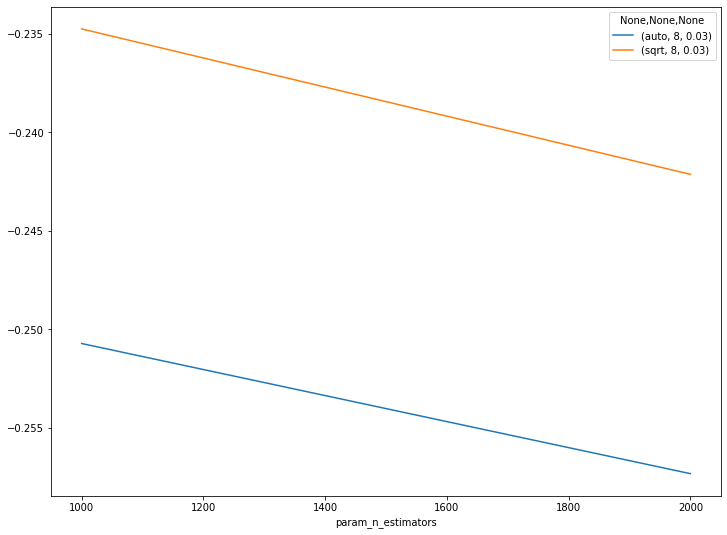

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.5min finished


Best estimator is :

GradientBoostingRegressor(learning_rate=0.03, max_depth=8, max_features='sqrt',
                          n_estimators=1000)
KFoldCV best score = -0.09226281697447489


c:\users\arnaud\documents\travail\ml_projects\bike_sharing\env\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


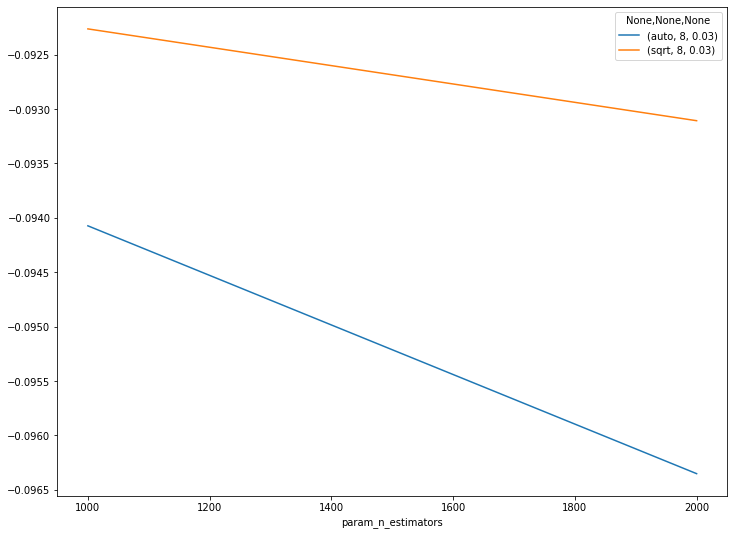

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.3min finished


Best estimator is :

GradientBoostingRegressor(learning_rate=0.03, max_depth=8, max_features='auto',
                          n_estimators=1000)
KFoldCV best score = -0.09145022902374042


c:\users\arnaud\documents\travail\ml_projects\bike_sharing\env\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


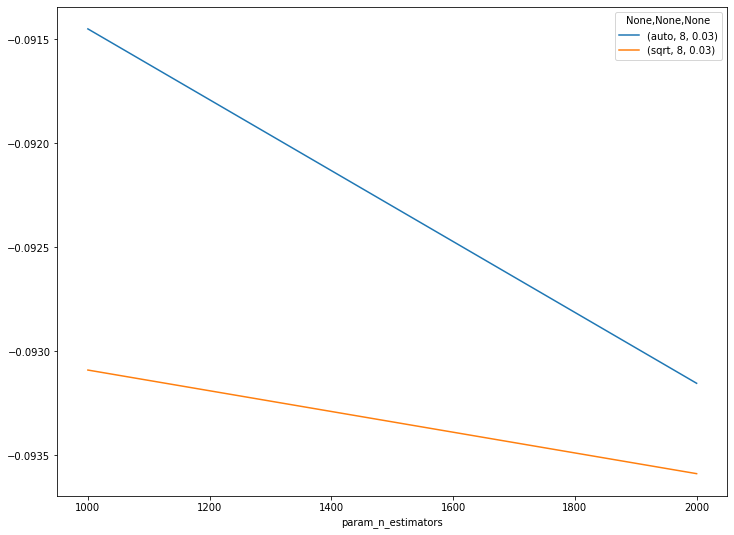

In [17]:
mdl_casual = optimize_and_train(X_train, y_train, 'casual')
mdl_registered = optimize_and_train(X_train, y_train, 'registered')
mdl_count = optimize_and_train(X_train, y_train, 'count')

## Study model performances on the test set

In [18]:
def make_predictions(model, X):
    predictions = np.expm1(model.predict(X))
    return predictions

In [19]:
def format_results(casual_preds, registered_preds, count_preds, y):
    results = np.expm1(y.copy())
    results['casual_preds'], results['registered_preds'], results['count_preds'] = casual_preds, registered_preds, count_preds
    results[results<0] = 0
    return results

In [20]:
def summarize_perfs(df):
    for target in ['casual', 'registered', 'count']:
        preds = target+'_preds'
        rmsle = np.sqrt(mean_squared_log_error(df[target], df[preds]))
        rmse = np.sqrt(mean_squared_error(df[target], df[preds]))
        print("Target is : {}".format(target))
        print("RMSLE = {}, \t RMSE = {}".format(rmsle, rmse))
        plot_results(df, target)
        
    rmsle = np.sqrt(mean_squared_log_error(df['count'], df['casual_preds']+df['registered_preds']))
    rmse = np.sqrt(mean_squared_error(df['count'], df['casual_preds']+df['registered_preds']))
    print("Target is : {}".format("composite count"))
    print("RMSLE = {}, \t RMSE = {}".format(rmsle, rmse))
    
    target = 'composite'
    plot_results(df, target)
    
    pass

In [21]:
def plot_results(df, target):
    # Sort the dataframe by datetimeindex for coherent time serie plots
    df.sort_index(inplace=True)

    if target == 'composite':
        y_preds = df['casual_preds']+df['registered_preds']
        y = df['count']
    else:
        y_preds = df[target+'_preds']
        y = df[target]
    
    fig, ax = plt.subplots(2, 2, figsize=(12,9))
    
    # Plot the time series of predictions and actual values
    ax[0][0].plot(df.index, y, color='g', alpha=0.6)
    ax[0][0].plot(df.index, y_preds, color='r', alpha=0.6)
    
    # Plot the predictions versus the actual values as a scatter plot
    ax[0][1].plot(y, y_preds, marker='o', linewidth=0, alpha=0.6)
    ax[0][1].plot(range(800), range(800), 'r-')
    
    # Plot the residuals as a time serie
    ax[1][0].plot(df.index, y_preds-y, color='r', alpha=0.6)
    ax[1][0].plot(df.index, [0 for _ in range(len(df))], 'b-')

    # Plot the histogram of the residuals
    ax[1][1].hist(x=(y_preds-y), bins=50)
    #ax[1][1].plot(x=[0 for _ in range(2)], y=[0, 600], 'r-')

    plt.show()
    
    pass

Target is : casual
RMSLE = 0.4587929353727062, 	 RMSE = 13.374565002007593


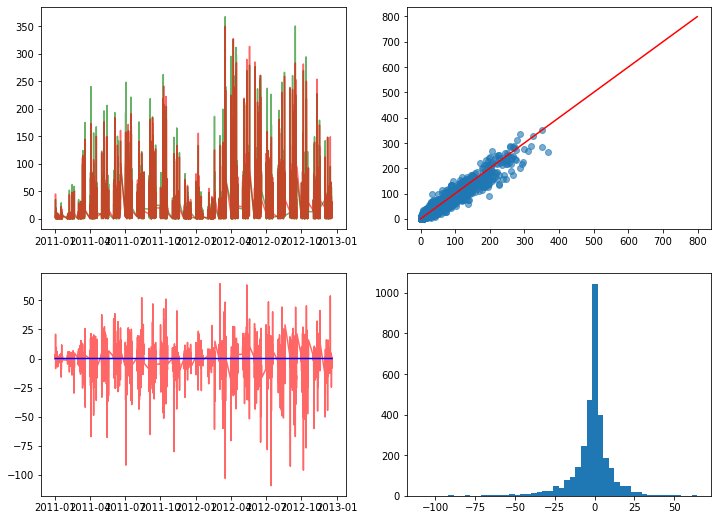

Target is : registered
RMSLE = 0.28211616531453565, 	 RMSE = 31.235108134062763


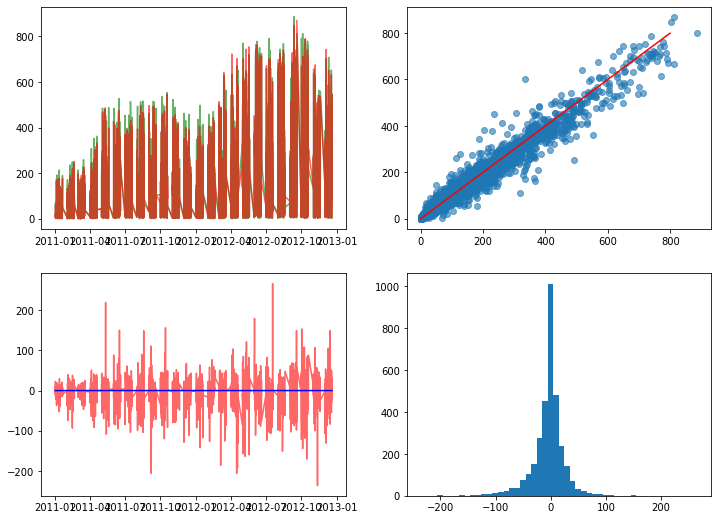

Target is : count
RMSLE = 0.2992476454066796, 	 RMSE = 37.516792447116906


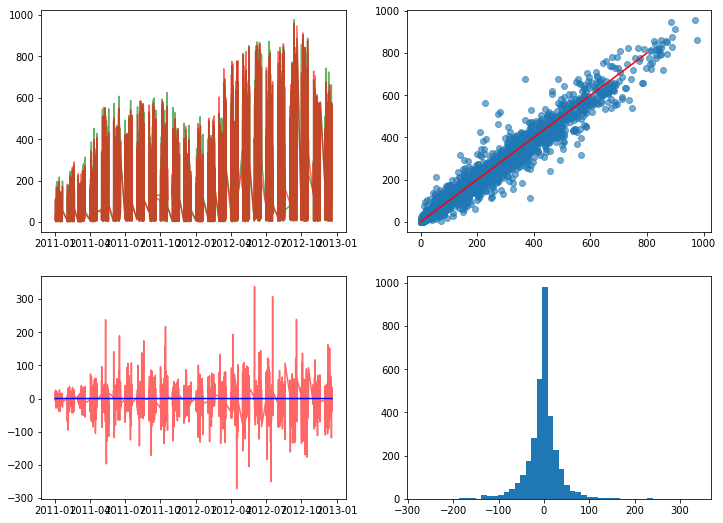

Target is : composite count
RMSLE = 0.28017224911550404, 	 RMSE = 36.71345837280558


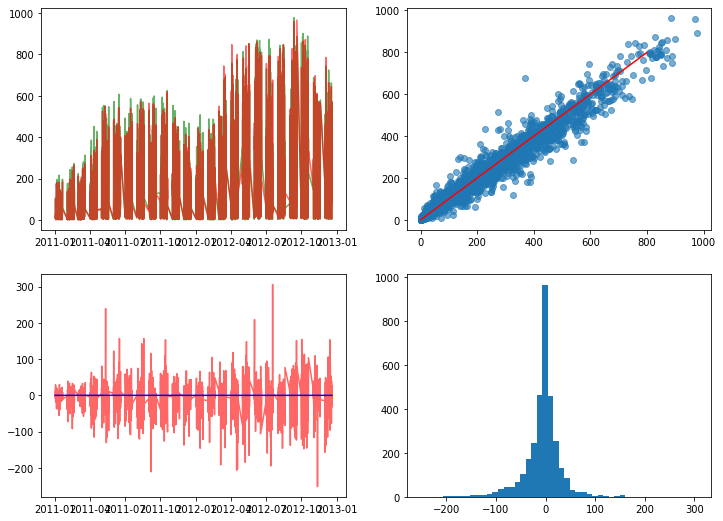

In [22]:
import mpld3
mpld3.enable_notebook()

casual_preds = make_predictions(mdl_casual, X_test)
registered_preds = make_predictions(mdl_registered, X_test)
count_preds = make_predictions(mdl_count, X_test)

results = format_results(casual_preds, registered_preds, count_preds, y_test)

summarize_perfs(results)

### Model properties

[Text(0, 0, 'season'),
 Text(0, 1, 'holiday'),
 Text(0, 2, 'workingday'),
 Text(0, 3, 'weather'),
 Text(0, 4, 'atemp'),
 Text(0, 5, 'humidity'),
 Text(0, 6, 'windspeed'),
 Text(0, 7, 'month'),
 Text(0, 8, 'year'),
 Text(0, 9, 'day'),
 Text(0, 10, 'hour'),
 Text(0, 11, 'vacations')]

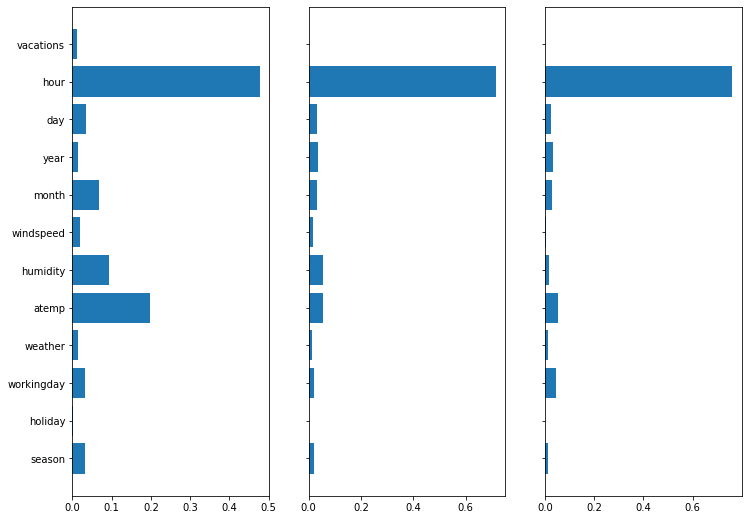

In [23]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12,9))

ax[0].barh(np.arange(len(features)), mdl_casual.feature_importances_)
ax[1].barh(np.arange(len(features)), mdl_registered.feature_importances_)
ax[2].barh(np.arange(len(features)), mdl_count.feature_importances_)
ax[0].set_yticks(np.arange(len(features)))
ax[0].set_yticklabels(features)

## Summary

We can see that the best models for casual, registered and count are not the same. We can also notice that we get better performances by using the ... model over the ... model.

## Making predictions for the competition

In [24]:
final_casual = retrain_model(mdl_casual, train[features], train[label], 'casual')
final_registered = retrain_model(mdl_registered, train[features], train[label], 'registered')
final_count = retrain_model(mdl_count, train[features], train[label], 'count')

In [25]:
def format_final_results(casual_preds, registered_preds, count_preds, test_df):
    results = pd.DataFrame({'datetime': test_df.index})
    results['casual_preds'], results['registered_preds'], results['count_preds'] = casual_preds, registered_preds, count_preds
    results['composite_preds'] = casual_preds+registered_preds
    #results['casual_preds'][results['casual_preds']<0] = 0
    return results

In [28]:
y_test_preds_casual = make_predictions(final_casual, test)
y_test_preds_registered = make_predictions(final_registered, test)
y_test_preds_count = make_predictions(final_count, test)

final_results = format_final_results(y_test_preds_casual, y_test_preds_registered, y_test_preds_count, test)

In [29]:
final_results['composite_preds'] = final_results['casual_preds'] + final_results['registered_preds']

submission_count = pd.DataFrame(data=test.index)
submission_composite = pd.DataFrame(data=test.index)

In [30]:
submission_count['count']=final_results['count_preds'].to_numpy()
submission_composite['count']=final_results['composite_preds'].to_numpy()

In [31]:
submission_count.to_csv('./submission_count.csv', index=False)
submission_composite.to_csv('./submission_composite.csv', index=False)

In [32]:
submission_composite.describe()

,count
count,6493.000000
mean,179.202988
std,167.040341
min,1.112259
25%,41.529700
50%,139.654135
75%,266.585891
max,957.362325
